In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import json


In [4]:
image_size = (192, 192)

In [5]:
def unet_model(input_size=(192, 192, 1)):
    inputs = Input(input_size)

    # Encoder (downsampling path)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (upsampling path)
    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u3 = concatenate([u3, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u1 = concatenate([u1, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [6]:
def load_json_data(json_file_path):
    with open(json_file_path, 'r') as jsonfile:
        return json.load(jsonfile)

def extract_segments(json_data):
    segments = {}
    for img in json_data:
        val = json_data[img]
        regions = val['regions']
        for region in regions:
            shape_attributes = region.get('shape_attributes', {})
            region_attributes = region.get('region_attributes', {})
            
            if region_attributes.get('Eye') == 'iris':
                x_points = shape_attributes.get('all_points_x', [])
                y_points = shape_attributes.get('all_points_y', [])
                segments[val['filename']] = list(zip(x_points, y_points))
    return segments

def traverse_data_folder(data_folder):
    all_segments = {}
    for root, _, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.json'):
                json_file_path = os.path.join(root, file)
                json_data = load_json_data(json_file_path)
                segments = extract_segments(json_data)
                all_segments.update(segments)
    return all_segments

def generate_mask(image_shape, coordinates):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    if coordinates:
        cv2.fillPoly(mask, [np.array(coordinates, dtype=np.int32)], 255)
    return mask

def apply_mask_to_image(image, mask):
    masked_image =  cv2.bitwise_and(image, image, mask=mask)
    if len(masked_image.shape) == 3 and masked_image.shape[2] == 3:
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    return masked_image


from IPython.display import clear_output

def get_segmented_images(images, names, segments):
    n_images = []
    shape = None
    for i in range(names.size):
        clear_output(wait=True)
        name = names[i]
        image = images[i]
        if (name not in segments):
            resized_img = cv2.resize(image, image_size)
            n_images.append(resized_img)
            continue
        segment = segments[name]
        print(image.shape)
        mask = generate_mask(image.shape, segment)
        masked_image = apply_mask_to_image(image, mask)
        resized_img = cv2.resize(masked_image, image_size)
        if shape == None:
            shape = resized_img.shape
        elif shape != resized_img.shape:
            print(shape)
            print(resized_img.shape)
            print(name)
            return
        n_images.append(resized_img)
        print(i)
    
    return n_images

def display_images(image, mask, masked_image, ffd="Image"):
    plt.figure(figsize=(15, 5))
    plt.title(ffd)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image : " + ffd)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Iris Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    plt.title('Masked Image')
    plt.show()

def showImg(index):
    ffd = 'Alcoholic' if labels[index] else 'Fit for Duty'
    image = images[index]
    name = names[index]
    if (name not in segments):
        print("Segmentation not found for this image")
        return
    segment = segments[name]
    print(image.shape)
    mask = generate_mask(image.shape, segment)
    masked_image = apply_mask_to_image(image, mask)
    display_images(image, mask, masked_image, ffd)
    print(names[index])




In [7]:
def load_images_from_folder(folder_path, max_depth = 5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    all_segments = {}

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue
        

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # img = cv2.resize(img, image_size)
                            images.append(img)
                            labels.append(file[6]!='0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
                
                if file.endswith('.json'):
                    json_file_path = os.path.join(root, file)
                    json_data = load_json_data(json_file_path)
                    segments = extract_segments(json_data)
                    all_segments.update(segments)

        else:
            del dirs[:]
    
    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")

    return np.array(images), np.array(labels), np.array(names), all_segments

In [8]:
images, _, names, segments = load_images_from_folder("data")
masks = get_segmented_images(images, names, segments)  # Segmented images as binary masks

# Resize images and masks to match input size
image_size = (192, 192)
images_resized = [cv2.resize(img, image_size) for img in images]
masks_resized = [cv2.resize(mask, image_size) for mask in masks]

images_resized = np.array(images_resized).reshape(-1, 192, 192, 1) / 255.0
masks_resized = np.array(masks_resized).reshape(-1, 192, 192, 1) / 255.0

# Train-test split
images_train, images_test, masks_train, masks_test = train_test_split(images_resized, masks_resized, test_size=0.3, random_state=42)


(480, 640)
2819


In [9]:
unet = unet_model(input_size=(192, 192, 1))
unet.summary()

# Train the model
history = unet.fit(images_train, masks_train, validation_split=0.1, epochs=10, batch_size=16)

# Test the model
test_loss, test_accuracy = unet.evaluate(images_test, masks_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


2024-12-07 19:11:38.685426: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-07 19:11:38.685453: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 19:11:38.685456: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 19:11:38.685494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 19:11:38.685506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 192,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 192,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 96,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 96,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 96,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 48,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 48,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 48,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 24, 24,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 24, 24,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 48, 48,    │    524,544 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 48, 48,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 48, 48,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 48, 48,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 96, 96,    │    131,200 │ conv2d_9[0][0]  

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-12-07 19:11:42.095918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


111/111 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8784 - loss: 0.2622 - val_accuracy: 0.8792 - val_loss: 0.1050
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8783 - loss: 0.1033 - val_accuracy: 0.8791 - val_loss: 0.0920
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.8776 - loss: 0.0898 - val_accuracy: 0.8791 - val_loss: 0.0861
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.8782 - loss: 0.0860 - val_accuracy: 0.8791 - val_loss: 0.0832
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8776 - loss: 0.0834 - val_accuracy: 0.8789 - val_loss: 0.0818
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8777 - loss: 0.0822 - val_accuracy: 0.8790 - val_loss: 0.0812
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8786 - loss: 0.0815 - val_accuracy: 0.8791 - val_loss: 0.0813
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.8783 - loss: 0.0812 - val_accuracy: 0.878

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


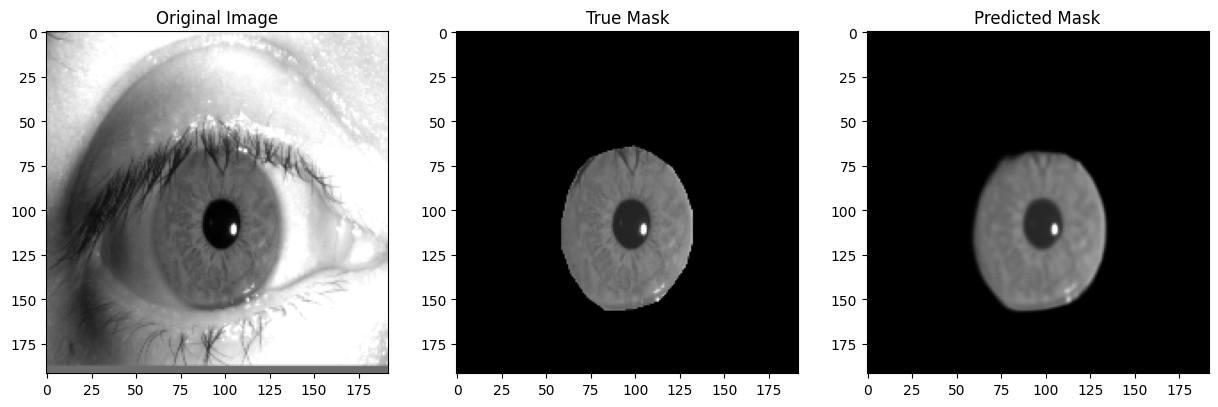

In [19]:
def display_prediction(image, mask, prediction):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('Original Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('True Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

# Test prediction
random_index = random.randint(0, len(images_test) - 1)
test_image = np.expand_dims(images_test[random_index], axis=0)
predicted_mask = unet.predict(test_image)

display_prediction(images_test[random_index], masks_test[random_index], predicted_mask)


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
dirt = "Models/SegmentationModelUnet"
if not os.path.exists(dirt):
    os.makedirs(dirt)
unet.save(f"{dirt}/model.keras")
unet.save(f"{dirt}/model.h5")